In [1]:
# standard python utilities
import os
import sys
from os.path import basename, dirname, join, exists
import glob
import pandas as pd
import numpy as np
import time
from scipy.stats import gmean

# standard geospatial python utilities
import geopandas as gpd
from osgeo import gdal
import rasterio

# import flopy
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
# dir of stream level data for seepage study
proj_dir = gwfm_dir + '/Oneto_Denier/'
dat_dir = proj_dir+'Stream_level_data/'

sfr_dir = gwfm_dir+'/SFR_data/'

In [3]:
out_dir = join(proj_dir, 'output')
fig_dir = join(proj_dir, 'figures')

In [4]:
flopy_dir = doc_dir+'/GitHub/flopy'
if flopy_dir not in sys.path:
    sys.path.insert(0, flopy_dir)
    
import flopy 

In [5]:
ext_dir = 'F:/WRDAPP'
c_dir = 'C:/WRDAPP'
if os.path.exists(ext_dir):
    loadpth = ext_dir 
elif os.path.exists(c_dir):
    loadpth = c_dir 
loadpth +=  '/GWFlowModel/Cosumnes/Stream_seepage'

upscale = 4 
upscale_txt = 'upscale'+str(upscale)+'x_'
# model_nam = 'inset_oneto_denier'
model_nam = 'oneto_denier_'+upscale_txt+'2014_2018'

base_model_ws = join(loadpth,model_nam)

# all_model_ws = join(loadpth, 'parallel_oneto_denier')
all_model_ws = join(loadpth, 'parallel_'+model_nam)

# may want to skip loading rch, evt and wel which take up a lot of memory with stress period data
load_only = ['DIS','UPW','SFR','OC']
m = flopy.modflow.Modflow.load('MF.nam', model_ws= base_model_ws, 
                                exe_name='mf-owhm.exe', version='mfnwt')


In [6]:
# write modelgrid to get updated row and col numbers specific to the child grid
grid_dir = join(gwfm_dir, 'DIS_data/streambed_seepage/grid')
grid_fn = join(grid_dir, 'inset_oneto_denier','rm_only_grid.shp')

# m.modelgrid.write_shapefile(grid_fn)
grid_p = gpd.read_file(grid_fn)
grid_p.crs = 'epsg:32610'
# elevation to grid for reference to land surface
dem_data = np.loadtxt(join(proj_dir, 'GIS','local_subset_dem_52_9_200m_mean.tsv'))
grid_p['dem_elev'] = dem_data[grid_p.row-1, grid_p.column-1]

In [7]:
sfr_facies_all = pd.read_hdf(join(out_dir, 'sfrdf_facies_sum.hdf5'))


In [8]:
sfr_last_all = pd.read_hdf(join(out_dir, 'sfrdf_last_seg.hdf5'))

Graham suggested we individually disect some of these results to better understand the impact of outcropping HCPs. A good presentation would be picking a realization that has low, middle, or high streamflow or by looking at the number of coarse segments since that is what is used as an independent variable in the correlation statistics. From there we can investigate the spatial aspects in some ways. Filter by looking at overall average streamflow at the outlet.

- look at location of coarse segments vs where baseflow/recharge happen.
- plot XS of channel to show heads in aquifer and stream and perhaps fluctuate over time to show how gravels change conditions

also looking at the best fit realization to show what reality is then diving into these other realizations to show how differences in spatial distribution can significantly alter stream function. The baseflow below here is a great example of how excess gravel scattered in the channel greatly increases connectivity and baseflow. We should demonstrate as well how this then plays into the timing and duration of in-stream flows to support the ecosystem.

In [9]:
stats_done = pd.read_csv(join(out_dir, 'hob_fit_stats.csv'),index_col=0)
top_rmse = stats_done[stats_done.RMSE<=stats_done.RMSE.quantile(0.03)]
top_rmse


,r2,RMSE,NSE
0,0.530724,1.978587,0.586458
42,0.566460,1.901759,0.587343
74,0.529985,1.980144,0.592193


In [10]:
ref_out = pd.read_csv(join(proj_dir, 'coarse_reference.csv'), index_col=0)


In [11]:
sfr_last_mean = sfr_last_all.groupby('realization').mean(numeric_only=True)['Qout']
# realizations to review
def per_idx(sfr_last_mean, per):
    idx = sfr_last_mean[sfr_last_mean.isin(np.percentile(sfr_last_mean, per, method='nearest'))].sort_values().index.values
    return idx
quants = [5, 25, 50, 75, 95]
# categorize by streamflow
r_review = per_idx(sfr_last_mean, quants)

# categorize by the number of coarse segments
r_review = ref_out[ref_out.num_sfr.isin(np.percentile(ref_out.num_sfr, quants, method='nearest'))]
r_review = r_review.drop_duplicates('num_sfr').sort_values('num_sfr').index.values

# consider the best fit as well
r_review = pd.DataFrame(np.append(r_review, top_rmse.index.values), columns=['realization'])
r_review['variable'] = np.append(['quant']*len(quants), ['fit']*len(top_rmse))
r_review['value'] = np.append(quants, top_rmse.RMSE).round(4)
r_review['num_coarse'] = ref_out.loc[r_review.realization, 'num_sfr'].values
# r_review
# coarse_ref.loc[r_review], sfr_last_mean[r_review]

In [12]:
ref_out.loc[r_review.realization, 'num_lak'].values

array([47, 14, 53, 27, 88, 81, 38, 25], dtype=int64)

In [13]:
grid_sfr_all = pd.DataFrame()
for r in r_review.realization: #100
    folder = 'realization'+ str(r).zfill(3)
    # update model workspace so outputs to right directory
    model_ws = join(all_model_ws, folder)
    grid_sfr = pd.read_csv(model_ws+'/grid_sfr.csv',index_col=0)
    grid_sfr = grid_sfr.drop(columns=['node','geometry','node.1'])
    grid_p_sfr = grid_p.set_index(['row','column']).loc[list(zip(grid_sfr.i+1,grid_sfr.j+1))].reset_index(drop=True)
    grid_sfr = pd.concat((grid_p_sfr,grid_sfr),axis=1)
    grid_sfr_all = pd.concat((grid_sfr_all, grid_sfr.assign(realization=r)))

Looking at the quantiles for the number of coarse stream segments it seems that the best fit realizations span the 5th to 75th percentile which means that we have multiple realizations with different stream segment connections but equal model fit which means that the larger subsurface distribution might account for the fit more than stream segments that outcrop.
- the top best fit realizations both had a higher number of coarse lake cells
- the other variable to plot would be the number of distinct connected bodies that outcrop or that are in the domain

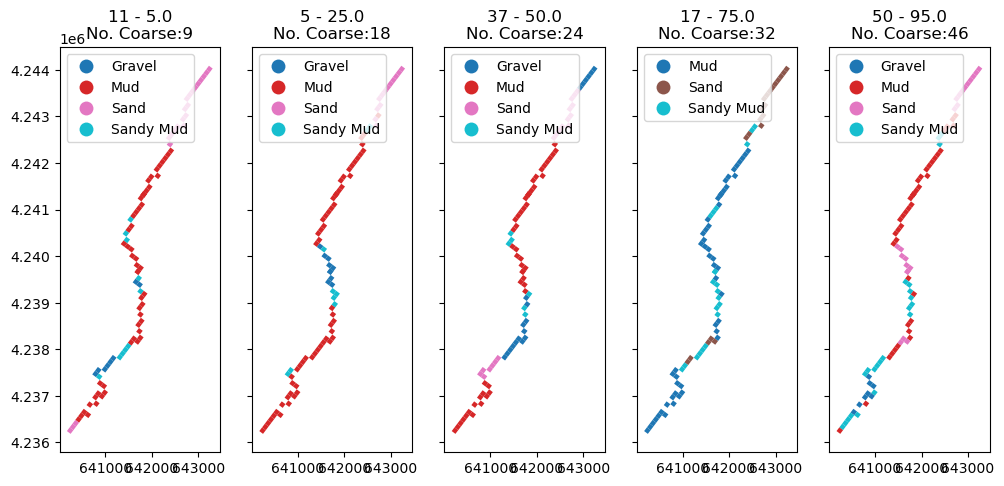

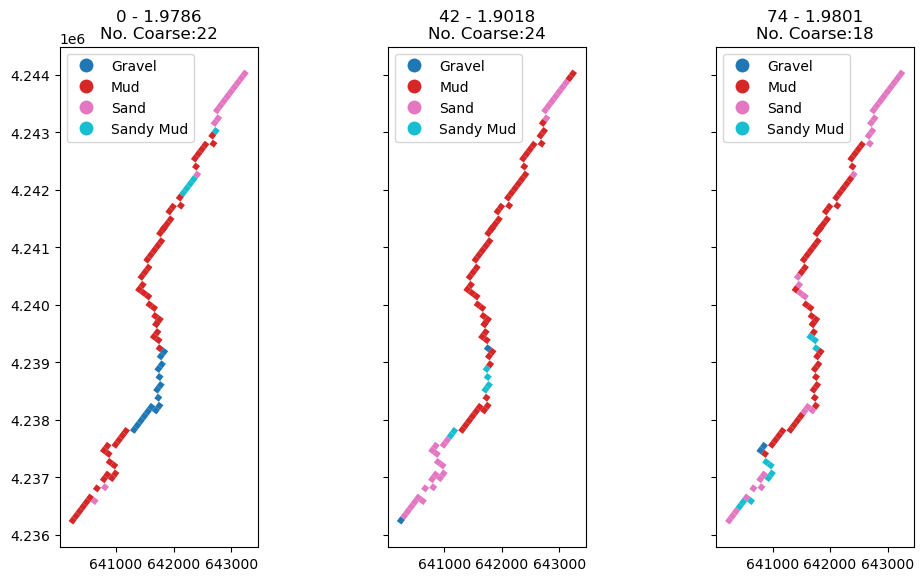

In [14]:
q_review = r_review[r_review.variable=='quant']
fig,ax = plt.subplots(1, len(q_review), sharex=True, sharey=True, figsize=(12, 6.5))
for nr, r in enumerate(q_review.realization):
    grid_sfr_all[grid_sfr_all.realization==r].plot('facies', ax=ax[nr], legend=True, legend_kwds={'loc':'upper left'})
    ax[nr].set_title(str(r)+' - '+str(q_review.value.iloc[nr])+'\nNo. Coarse:'+str(q_review.num_coarse.iloc[nr]))
# grid_sfr_all[grid_sfr_all.realization==r].plot('facies', legend=True, ax=ax[-1])

q_review = r_review[r_review.variable=='fit']
fig,ax = plt.subplots(1, len(q_review), sharex=True, sharey=True, figsize=(12, 6.5))
for nr, r in enumerate(q_review.realization):
    grid_sfr_all[grid_sfr_all.realization==r].plot('facies', ax=ax[nr], legend=True, legend_kwds={'loc':'upper left'})
    ax[nr].set_title(str(r)+' - '+str(q_review.value.iloc[nr])+'\nNo. Coarse:'+str(q_review.num_coarse.iloc[nr]))

## Segment facies review
Three of the five realizations show the expected behavior of primarily mud with patches of sand, sandy mud and gravel. The outlier is a realization that is probably half gravel and sand as the stream bed facies which is the same realization where there was a huge amount of baseflow in the gravel. There is also a realization that is almost entirely mud with a section of NAs for some reason.  

The realizations with best fit all tend to have dominantly mud in the upper and lower sections with a gravel pocket along the middle section. The other realizations tend to keep this pattern with variability in the length of the gravel section.

In [15]:
lakrow, lakcol = np.where(m.lak.lakarr.array[0].mean(axis=0) >0)
grid_lak = grid_p.set_index(['row','column']).loc[list(zip(lakrow+1,lakcol+1))].reset_index(drop=True)


In [16]:
xs = gpd.read_file(join(proj_dir, 'GIS', 'plotting_cross_section_lines.shp'))
grid_xs = gpd.sjoin(grid_p, xs) # grid cells for each XS
# set standard cell numbers for XS plotting
for n in  np.arange(0, len(xs)):
    grid_xs.loc[grid_xs.id==n, 'xs_cell']  = np.arange(0, (grid_xs.id==n).sum())

In [17]:
grid_sfr[['row','column']] = grid_sfr[['i','j']]+1
# grid_sfr

In [20]:
# find sfr, lak cells that are in the xs
sfr_xs = grid_xs.join(grid_sfr.set_index(['row','column']).drop(columns=['geometry','node', 'dem_elev']), on=['row','column'], how='inner')
lak_xs = grid_xs.join(grid_lak.set_index('node').drop(columns=['geometry', 'dem_elev']), on='node', how='inner')


In [21]:
# grid_xs.plot('xs_cell', legend=True)

<Axes: >

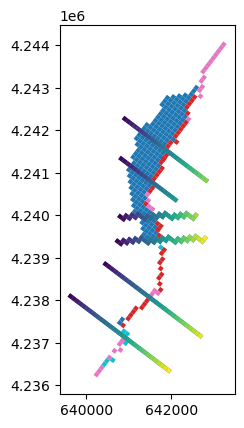

In [22]:
ax=grid_lak.plot()
grid_sfr.plot('facies', ax=ax)
grid_xs.plot(ax=ax)
grid_xs.plot('xs_cell', ax=ax)

It would make sense to have a XS in the middle of the floodplain, at the bottom edge where the gravel patch tends to be in the river and a little further downstream near the outlet.

## Deeper geologic review
Following the segment facies review, there are geologic features that may be adjacent to the channel but not outcrop that could impact flow but this is more difficult to represent. I think plotting these XS with head values and geologic facies are a good way to dive a little deeper at a 2D level. It would also be worthwhile presenting groundwater contours at key points (flood peak, recession and summer low).

In [ ]:
## identify XS line to plot

In [ ]:
r = 11

In [ ]:
folder = 'realization'+ str(r).zfill(3)
# update model workspace so outputs to right directory
model_ws = join(all_model_ws, folder)
# m.model_ws = model_ws
upw_r = flopy.modflow.ModflowUpw.load(model_ws+'/MF.upw', model=m)
# model_ws+'/MF.upw'

In [ ]:
hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
spd_stp = hdobj.get_kstpkper()
times = hdobj.get_times()

# get ALL stress periods and time steps list, not just those in the output
kstpkper = []
for n,stps in enumerate(m.dis.nstp.array):
    kstpkper += list(zip(np.arange(0,stps),np.full(stps,n)))

# dt_ref = pd.DataFrame(dates_stps, columns=['dt'])
# dt_ref['kstpkper'] = kstpkper
# dt_ref

In [ ]:
# for n in xs.id:
for n in [2]:
    xs_n = grid_xs[grid_xs.id==n]
    xs_hk = upw_r.hk.array[:, xs_n.row-1, xs_n.column-1]
    
    sfr_xs_n = sfr_xs[sfr_xs.id==n]
    lak_xs_n = lak_xs[lak_xs.id==n]


In [ ]:
# plt.imshow(xs_hk)
xs_hk[0]
ymax = m.dis.top.array.max()
ymin = m.dis.botm.array.min()

In [ ]:
# polygon = ax.fill_between(x, y1, y2, lw=0, color='none')
# ax.margins(x=0.02)
# xlim = ax.get_xlim()
# ylim = ax.get_ylim()
# verts = np.vstack([p.vertices for p in polygon.get_paths()])
plt.imshow(xs_hk, cmap='viridis', aspect='auto',
                    extent=[xs_n.xs_cell.min(), xs_n.xs_cell.max(), ymin, ymax]
                    # extent=[verts[:, 0].min(), verts[:, 0].max(), verts[:, 1].min(), verts[:, 1].max()]
                   )
# filling.set_clip_path(polygon.get_paths()[0], transform=ax.transData)
# ax.set_xlim(xlim) # the limits need to be set again because imshow sets zero margins
# ax.set_ylim(ylim)

In [ ]:


head = hdobj.get_data(spd_stp[1200])[:, xs_n.row-1, xs_n.column-1] 
head = np.ma.masked_where(head==-999.99, head)

# when considering how to plot head we should focus on the upper layers where the river interacts
# it appears the heads under the river/lake stay constant
# for n in np.arange(head.shape[0]):
#     plt.plot(xs_n.xs_cell, head[n]);

def plt_xs_spd(head, sfr_xs_n, lak_xs_n, xs_n, ax):
    # plot head in sfr layer only
    head_sfr = head[sfr_xs_n.k.values[0]]
    ax.plot(head_sfr, color='blue', label='Head in SFR layer')
    # plot average head as well
    head_avg = head[0:10].mean(axis=0)
    ax.plot(head_avg, color='blue', linestyle='--', label='Average Head - Upper')
    head_avg = head[10:-1].mean(axis=0)
    ax.plot(head_avg, color='blue', linestyle='-.', label='Average Head - Lower')
    head_avg = head[-1]
    ax.plot(head_avg, color='blue', linestyle=':', label='Head - Deep')

    # plot sfr and lak stages
    ax.scatter(sfr_xs_n.xs_cell, sfr_xs_n.strtop, zorder= -1, color='tab:blue', label='Stream Top')
    ax.scatter(lak_xs_n.xs_cell, lak_xs_n.dem_elev, zorder= -2, color='brown', label='Lake')
    ax.plot(xs_n.xs_cell, xs_n.dem_elev, zorder= -3, color='black', label='Land Surface')
    


In [ ]:
fig, ax = plt.subplots(len(xs.id), figsize=(6,6), sharex=True, sharey=True)
for n in xs.id:
    xs_n = grid_xs[grid_xs.id==n]
    xs_hk = upw_r.hk.array[:, xs_n.row-1, xs_n.column-1]
    
    sfr_xs_n = sfr_xs[sfr_xs.id==n]
    lak_xs_n = lak_xs[lak_xs.id==n]

    
    head = hdobj.get_data(spd_stp[1200])[:, xs_n.row-1, xs_n.column-1] 
    head = np.ma.masked_where(head==-999.99, head)

    plt_xs_spd(head, sfr_xs_n, lak_xs_n, xs_n, ax=ax[n])

In [ ]:
fig, ax = plt.subplots(len(xs.id), figsize=(6,6), sharex=True, sharey=True)
for n in xs.id:
    xs_n = grid_xs[grid_xs.id==n]
    xs_hk = upw_r.hk.array[:, xs_n.row-1, xs_n.column-1]
    
    sfr_xs_n = sfr_xs[sfr_xs.id==n]
    lak_xs_n = lak_xs[lak_xs.id==n]

    
    head = hdobj.get_data(spd_stp[1200])[:, xs_n.row-1, xs_n.column-1] 
    head = np.ma.masked_where(head==-999.99, head)

    plt_xs_spd(head, sfr_xs_n, lak_xs_n, xs_n, ax=ax[n])